In [2]:
from keras.applications.vgg16 import VGG16

 Instantiating the VGG16 convolutional base

In [3]:
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

 Extracting features using the pretrained convolutional base

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [6]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-12-31 23:29:08--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   139MB/s    in 0.5s    

2021-12-31 23:29:09 (139 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [7]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory /tmp/cats_and_dogs_filtered, which contains train and validation subdirectories for the training and validation datasets

In [8]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [9]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [10]:
def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
  directory,
  target_size=(150, 150),
  batch_size=batch_size,
  class_mode='binary')
  i=0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
     break
  return features, labels

In [11]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
train_features.shape

(2000, 4, 4, 512)

The extracted features are currently of shape (samples, 4, 4, 512).
 must flatten them to (samples, 8192):

In [13]:
train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))

Defining and training the densely connected classifier

In [17]:
from keras import models
from keras import layers
from keras import optimizers
import tensorflow

In [18]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=tensorflow.keras.optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])
history = model.fit(train_features, train_labels,epochs=30,batch_size=20,validation_data=(validation_features, validation_labels))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/30
100/100 [==============================] - 2s 8ms/step - loss: 0.5991 - acc: 0.6775 - val_loss: 0.4709 - val_acc: 0.7950
Epoch 2/30
100/100 [==============================] - 1s 6ms/step - loss: 0.4190 - acc: 0.8135 - val_loss: 0.3722 - val_acc: 0.8440
Epoch 3/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3570 - acc: 0.8535 - val_loss: 0.3303 - val_acc: 0.8700
Epoch 4/30
100/100 [==============================] - 1s 7ms/step - loss: 0.3222 - acc: 0.8640 - val_loss: 0.3181 - val_acc: 0.8700
Epoch 5/30
100/100 [==============================] - 1s 7ms/step - loss: 0.2929 - acc: 0.8815 - val_loss: 0.3037 - val_acc: 0.8770
Epoch 6/30
100/100 [==============================] - 1s 7ms/step - loss: 0.2655 - acc: 0.8960 - val_loss: 0.2933 - val_acc: 0.8780
Epoch 7/30
100/100 [==============================] - 1s 7ms/step - loss: 0.2482 - acc: 0.9075 - val_loss: 0.2761 - val_acc: 0.8810
Epoch 8/30
100/100 [==============================] - 1s 7ms/step - loss: 0.

 Plotting the results

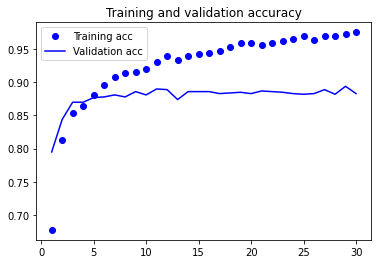

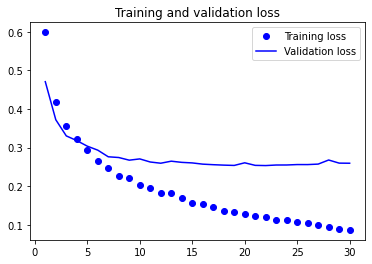

In [19]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

data augmentation, which is essential
for preventing overfitting with small image datasets. 

FEATURE EXTRACTION WITH DATA AUGMENTATION

data augmentation during training: extending the conv_base model and running it end to end on the inputs

Adding a densely connected classifier on top of the convolutional base

In [20]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Freezing a layer or set of layers means preventing their weights from being
updated during training. If you don’t do this, then the representations that were previously learned by the convolutional base will be modified during training. Because
the Dense layers on top are randomly initialized, very large weight updates would be
propagated through the network, effectively destroying the representations previously
learned.

 In Keras, you freeze a network by setting its trainable attribute to False:

In [22]:
 print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [23]:
conv_base.trainable = False

In [24]:
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


 Training the model end to end with a frozen convolutional base

In [25]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

 the
validation data
shouldn’t be
augmented!

In [26]:
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

In [28]:
test_datagen = ImageDataGenerator(rescale=1./255)

Because you use 
binary_crossentropy 
loss,hence binary labels

In [29]:
train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
validation_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
model.compile(optimizer=tensorflow.keras.optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [32]:
history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=100,
validation_data=validation_generator,
validation_steps=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
100/100 [==============================] - 34s 329ms/step - loss: 0.5814 - acc: 0.7070 - val_loss: 0.4273 - val_acc: 0.8230
Epoch 2/100
100/100 [==============================] - 30s 299ms/step - loss: 0.4690 - acc: 0.7960 - val_loss: 0.3776 - val_acc: 0.8230
Epoch 3/100
100/100 [==============================] - 31s 306ms/step - loss: 0.4214 - acc: 0.8150 - val_loss: 0.3304 - val_acc: 0.8600
Epoch 4/100
100/100 [==============================] - 30s 300ms/step - loss: 0.3848 - acc: 0.8430 - val_loss: 0.3126 - val_acc: 0.8620
Epoch 5/100
100/100 [==============================] - 30s 299ms/step - loss: 0.3740 - acc: 0.8370 - val_loss: 0.3002 - val_acc: 0.8670
Epoch 6/100
100/100 [==============================] - 30s 298ms/step - loss: 0.3532 - acc: 0.8425 - val_loss: 0.3013 - val_acc: 0.8700
Epoch 7/100
100/100 [==============================] - 30s 299ms/step - loss: 0.3648 - acc: 0.8330 - val_loss: 0.2839 - val_acc: 0.8730
Epoch 8/100
100/100 [===========================

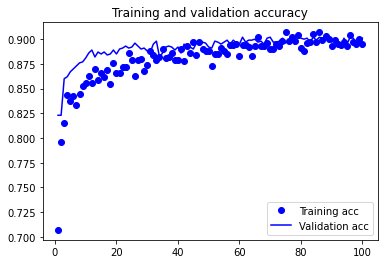

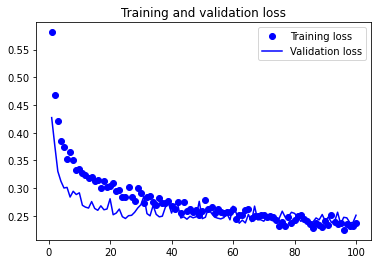

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [35]:
model.save('cats_and_dogs_vgg16_model.h5')

#### Refrence book DeepLearning with Python